# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
# from environment import CacheEnv
from e2 import CacheEnv
# from environment import scheduler
%load_ext autoreload
%autoreload 2

In [2]:
# env vars
EPS_LEN = 100
N_PAGES = 20
CACHE_LIMIT = 10 
env = CacheEnv(
        eps_len=EPS_LEN, 
        n_pages=N_PAGES, 
        limit=CACHE_LIMIT
        )

# dqn vars
# N_EPS = 60000
N_EPS = 5000
BATCH_SIZE = 32
# LR = 3e-4                   # learning rate for Adam
LR = 1e-2                   # learning rate for SGD
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 2000   # target update frequency
MEMORY_CAPACITY = 20000
MEMORY_CAPACITY = 8000

s = env.reset()
N_ACTIONS = env.action_space_n
STATE_SHAPE = (CACHE_LIMIT, 2)
N_STATES = STATE_SHAPE[0]*STATE_SHAPE[1]

Cache limit: 10
Total Pages: 20


In [3]:
print(N_ACTIONS)
print(N_STATES)

10
20


In [5]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        input_size = N_STATES
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 100)
        self.out = nn.Linear(10, N_ACTIONS)

    def forward(self, x):
#         bs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = self.out(x)
        return F.softmax(x, dim=0)

In [6]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net().cuda(), Net().cuda()
        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
#         self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.optimizer = torch.optim.SGD(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()
        self.PATH = 'model/'

    def choose_action(self, x):
#         print(f"X for choose action: {x}")
        x = torch.unsqueeze(torch.FloatTensor(x), 0).cuda()
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net(x).detach().cpu()
            action = torch.argmax(actions_value).cpu().data.numpy()
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES]).cuda()
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int)).cuda()
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2]).cuda()
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:]).cuda()

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1) 
#         q_eval = self.eval_net(b_s)  # shape (batch, 1) 
        
        q_next = self.target_net(b_s_).detach()   # detach from graph, don't backpropagate
#         q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        q_target = b_r + GAMMA * q_next.argmax(dim=1).view(BATCH_SIZE, 1)   # shape (batch, 1)
        
        self.q_target = q_target
        self.q_eval = q_eval
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def save_model(self, eval_name = 'eval_net', train_name = 'train_net'):
        torch.save(self.eval_net.state_dict(), self.PATH  + str(N_STATES) + eval_name)
        torch.save(self.target_net.state_dict(), self.PATH  + str(N_STATES)+ train_name)
        
    def load_model(self, eval_name = 'eval_net.m', train_name = 'train_net.m'):
        self.eval_net.load_state_dict(torch.load(self.PATH +  str(N_STATES) + eval_name))
        self.target_net.load_state_dict(torch.load(self.PATH  + str(N_STATES) + train_name))

In [7]:
start = time.time()
dqn = DQN()
# dqn.load_model()
print("Start")
print('\nCollecting experience...')
history = []
for i_episode in range(N_EPS):
    s = env.reset()
    ep_r = 0
    n = 0
    while True:
        a = dqn.choose_action(s)
        s_, r, done, info = env.step(a)
        dqn.store_transition(s, a, r, s_)
        ep_r += r
        n += 1
        
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
        
        if done:
            history.append(ep_r)
            if (dqn.memory_counter > MEMORY_CAPACITY) and i_episode%100==0:
                print('Ep: ', i_episode, '| Ep_r: ', ep_r, f'Ran for: {n} timesteps')
            break

        s = s_
end = time.time()

Start

Ep:  100 | Ep_r:  194 Ran for: 100 timesteps
Ep:  200 | Ep_r:  115 Ran for: 100 timesteps
Ep:  300 | Ep_r:  163 Ran for: 100 timesteps
Ep:  400 | Ep_r:  90 Ran for: 100 timesteps
Ep:  500 | Ep_r:  100 Ran for: 100 timesteps
Ep:  600 | Ep_r:  76 Ran for: 100 timesteps
Ep:  700 | Ep_r:  137 Ran for: 100 timesteps
Ep:  800 | Ep_r:  88 Ran for: 100 timesteps
Ep:  900 | Ep_r:  139 Ran for: 100 timesteps
Ep:  1000 | Ep_r:  107 Ran for: 100 timesteps
Ep:  1100 | Ep_r:  136 Ran for: 100 timesteps
Ep:  1200 | Ep_r:  157 Ran for: 100 timesteps
Ep:  1300 | Ep_r:  137 Ran for: 100 timesteps
Ep:  1400 | Ep_r:  109 Ran for: 100 timesteps
Ep:  1500 | Ep_r:  211 Ran for: 100 timesteps
Ep:  1600 | Ep_r:  150 Ran for: 100 timesteps
Ep:  1700 | Ep_r:  140 Ran for: 100 timesteps
Ep:  1800 | Ep_r:  97 Ran for: 100 timesteps
Ep:  1900 | Ep_r:  110 Ran for: 100 timesteps
Ep:  2000 | Ep_r:  115 Ran for: 100 timesteps
Ep:  2100 | Ep_r:  102 Ran for: 100 timesteps
Ep:  2200 | Ep_r:  203 Ran for: 100 time

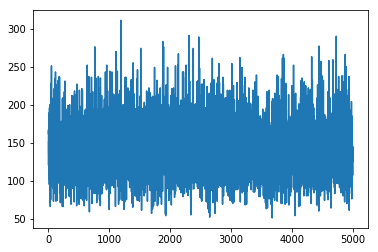

In [9]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show()

# Debugging

In [10]:
# Debugggging
print(dqn.q_eval.shape)
print(dqn.q_target.shape)

torch.Size([32, 1])
torch.Size([32, 1])


In [11]:
def pretty_print(s):
    for i, x in enumerate(s):
        if i == len(s)-1:
            end = '\n'
        elif i%2 == 0:
            end = '-'
        else:
            end = ', ' 
        print(x, end=end)

In [22]:
# s = env.reset()
a = dqn.choose_action(s)
pretty_print(s)
print(f"Chosen action: {a}")
s, r, done, info = env.step(a)
pretty_print(s)
state = torch.Tensor(s).cuda()
out1 = dqn.target_net(state).cpu().detach().numpy()
out2 = dqn.eval_net(state).cpu().detach().numpy()
print(out1)
print(out2)

print(out1.argmax())
print(out2.argmax())

11-8, 3-25, 18-13, 14-23, 159-3, 9-28, 52-6, 2-15, 1-9, 4-5
Chosen action: 2
12-8, 4-25, 1-25, 15-23, 160-3, 10-28, 53-6, 3-15, 2-9, 5-5
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
3
3


In [ ]:
6-2, 10-1, 2-2, 10-1, 10-1, 10-1, 4-3, 1-2, 10-1, 3-1

In [ ]:
net = Net().cuda()
out = net(state)
print(out)

In [ ]:
out.max(dim=0)